In [75]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

### Data

In [102]:
# r'Users/amandaquay/Box\ Sync/90904_FinalProject/SanJoaquinSalinityML/
pathway = 'data_average_after.csv'
df = pd.read_csv(pathway, index_col=0).dropna()     
# extract independent variables of use
df_small = df[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
               'slope', 'margins', 'average_temperature', 'total_precipitation']]
df_small.head()

,salinity,Field_ID,max_CRSI,elevation,aspect,slope,margins,average_temperature,total_precipitation
0,0.010,1.0,0.774290,66,328,1,1.0,285.08047,119.0
1,1.997,1.0,0.773924,66,340,0,1.0,285.08047,119.0
2,3.827,1.0,0.781937,66,152,0,1.0,285.08047,119.0
3,3.080,1.0,0.775323,66,151,0,1.0,285.08047,119.0
4,1.092,1.0,0.766537,66,149,0,1.0,285.08047,119.0


In [111]:
df_outlier_removed = df[df.Field_ID != 20.0]
print(df.size, "-->", df_outlier_removed.size, "samples when field 20 removed")

324005 --> 315755 samples when field 20 removed


In [112]:
df_small_outlier_removed = df_outlier_removed[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
                                               'slope', 'margins', 'average_temperature', 'total_precipitation']]
df_small_outlier_removed.head()

,salinity,Field_ID,max_CRSI,elevation,aspect,slope,margins,average_temperature,total_precipitation
0,0.010,1.0,0.774290,66,328,1,1.0,285.08047,119.0
1,1.997,1.0,0.773924,66,340,0,1.0,285.08047,119.0
2,3.827,1.0,0.781937,66,152,0,1.0,285.08047,119.0
3,3.080,1.0,0.775323,66,151,0,1.0,285.08047,119.0
4,1.092,1.0,0.766537,66,149,0,1.0,285.08047,119.0


### Functions

In [104]:
# input:  dataframe, optional specification of field to leave out  (otherwise will select randomly)
# output: LOFO rows set as X_test (features) and y_test (target);
#         non-LOFO rows set as X_train (features) and y_train (target)

def train_test_split_lofo(df, test_field=None):
    fields = df['Field_ID'].unique()
    if test_field is None: test_field = np.array([np.random.choice(fields)])
    else: test_field=np.array([test_field])
    train_fields = np.setdiff1d(fields, test_field)

    test_field_indices = np.where(df['Field_ID'].isin(test_field))[0]
    train_field_indices = np.where(df['Field_ID'].isin(train_fields))[0]

    y = df['salinity'].values.reshape(-1,1)
    X = df.drop(['Field_ID', 'salinity'], axis=1).values

    y_train = y[train_field_indices]
    y_test = y[test_field_indices]
    X_train = X[train_field_indices]
    X_test = X[test_field_indices]

    return X_train, y_train, X_test, y_test

In [128]:
# input:  dataframe
# output: y_hat (predictions for y_test using X_test and model LinearRegression);
#         mse (mean sq. error comparing y_hat with y_test)

def cross_validate_lofo(df):
    
    y_hat = np.array([])
    fields = df['Field_ID'].unique()
    
    for field in fields:
        X_train, y_train, X_test, y_test = train_test_split_lofo(df, field)
        model = linear_model.LinearRegression()
        model.fit(X_train, y_train)
        y_hat = np.append(y_hat, model.predict(X_test)) # predictions
        print(field, ": MSE =", np.mean((y_test - y_hat)**2))
    
    mse = np.mean((y - y_hat)**2)
    
    return y_hat, mse

In [106]:
# input: actual and predicted y_test, ylim and xlim optional if the frame needs to be expanded for some reason
# output: plot of actual and predicted salinity for test field(s)
def plot_actual_vs_predicted(actual, predicted, ylim=(0,40), xlim=(0,40)):
    plt.scatter(actual, predicted, s=5)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot((0,40),(0,40), linewidth=2, color='black')
    plt.xlabel('Actual Salinity (dS/m)')
    plt.ylabel('Predicted Salinity (dS/m)')
    plt.show()

### Univariate Linear Regression (LOFO): max_CRSI --> salinity
#### Full Dataset

In [118]:
# univariate using max_CRSI as sole feature
y = df['salinity'].values
X = df['max_CRSI'].values.reshape(len(df),1)

In [120]:
y_hat, mse = cross_validate_lofo(df[['Field_ID', 'salinity', 'max_CRSI']])

1.0 : 63.222085790962275
2.0 : 68.98064646489625
3.0 : 36.84913111926726
4.0 : 31.168526078124778
5.0 : 23.50778894653793
6.0 : 33.82142888153817
7.0 : 32.727685729941335
8.0 : 16.55286820092874
9.0 : 16.695783324813412
10.0 : 91.09992410548611
11.0 : 46.768970059504255
12.0 : 56.618752227636286
13.0 : 45.60232563785231
14.0 : 23.336807882626786
15.0 : 30.02446433243987
16.0 : 39.31230559252185
17.0 : 23.58373204533556
18.0 : 106.25967966254345
19.0 : 15.153859237097384
20.0 : 534.1869765032071
21.0 : 61.218247699507906
22.0 : 52.929292512716884


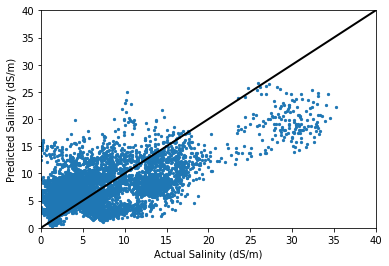

In [121]:
plot_actual_vs_predicted(y, y_hat)

In [122]:
print('MAE: %.2f' % np.mean(abs(y_hat - y)))
print('MSE: %.2f' % np.mean((y_hat-y)**2))
print('RMSE: %.2f' % np.mean(((y_hat-y)**2)**.5))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 3.85
MSE: 23.03
RMSE: 3.85
R_squared: 0.39


#### Removing Outlier Field (Field #20)

In [124]:
# univariate using max_CRSI as sole feature
y = df_outlier_removed['salinity'].values
X = df_outlier_removed['max_CRSI'].values.reshape(len(df_outlier_removed),1)

In [125]:
y_hat, mse = cross_validate_lofo(df_outlier_removed[['Field_ID', 'salinity', 'max_CRSI']])

1.0 : 49.03984233198163
2.0 : 55.3037855204318
3.0 : 30.089744412769132
4.0 : 25.17372672553572
5.0 : 18.028145143581302
6.0 : 27.186011297468482
7.0 : 26.054549629141775
8.0 : 11.842480439549723
9.0 : 12.443306601842103
10.0 : 92.98331881713408
11.0 : 40.34764685727061
12.0 : 50.212927866204495
13.0 : 39.849861448988186
14.0 : 18.435926218941294
15.0 : 25.369736330294042
16.0 : 34.71605127666425
17.0 : 19.8136487273987
18.0 : 103.12052692277723
19.0 : 10.659056056115846
21.0 : 58.38266303979057
22.0 : 50.91088957181932


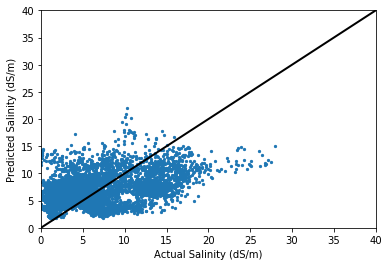

In [126]:
plot_actual_vs_predicted(y, y_hat)

In [127]:
print('MAE: %.2f' % np.mean(abs(y_hat - y)))
print('MSE: %.2f' % np.mean((y_hat-y)**2))
print('RMSE: %.2f' % np.mean(((y_hat-y)**2)**.5))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 3.82
MSE: 21.03
RMSE: 3.82
R_squared: 0.16


### Multivariate Linear Regression (LOFO): max_CRSI, elevation, aspect, slope, margins, average_temperature, total_precipitation --> salinity 
#### Full Dataset

In [107]:
y = df_small['salinity'].values
drop_columns = [0, 1] # drop_columns: salinity and field ID
X = df_small.drop(df_small.columns[drop_columns], axis = 1).values

In [108]:
y_hat, mse = cross_validate_lofo(df_small) # Looks like Field 20 is the problem child

1.0 : 77.16815131058169
2.0 : 79.53525510666881
3.0 : 40.21132348741112
4.0 : 42.60047903252644
5.0 : 31.85947346859876
6.0 : 37.83078856684306
7.0 : 36.55071091561413
8.0 : 21.603630720766095
9.0 : 21.7662372922778
10.0 : 102.06049179860747
11.0 : 48.72555389412913
12.0 : 58.244699212438746
13.0 : 47.250706449251055
14.0 : 25.425395384301407
15.0 : 31.87616218405843
16.0 : 41.662723190573644
17.0 : 25.721234330738184
18.0 : 107.20047393372619
19.0 : 16.929733324563145
20.0 : 535.4839949951398
21.0 : 61.44031794349903
22.0 : 53.65609286185748


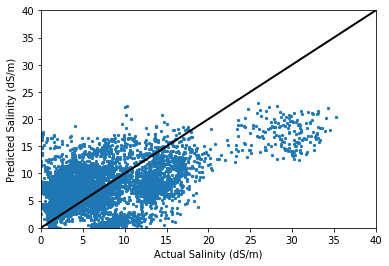

In [109]:
plot_actual_vs_predicted(y, y_hat)

In [110]:
print('MAE: %.2f' % np.mean(abs(y_hat - y)))
print('MSE: %.2f' % np.mean((y_hat-y)**2))
print('RMSE: %.2f' % np.mean(((y_hat-y)**2)**.5))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 4.36
MSE: 29.02
RMSE: 4.36
R_squared: 0.23


#### Removing Outlier Field (Field #20)

In [113]:
y = df_small_outlier_removed['salinity'].values
drop_columns = [0, 1]
X = df_small_outlier_removed.drop(df_small.columns[drop_columns], axis = 1).values

In [114]:
y_hat, mse = cross_validate_lofo(df_small_outlier_removed) # so now field 20 won't exist

1.0 : 66.5261740686076
2.0 : 69.59060781953666
3.0 : 33.72774618442844
4.0 : 32.451117200899446
5.0 : 23.48033765893374
6.0 : 33.87247856020892
7.0 : 32.70286417633898
8.0 : 16.9496503679478
9.0 : 17.333627617734617
10.0 : 97.12869736447905
11.0 : 44.17285784923647
12.0 : 53.56012168052503
13.0 : 43.02554893950238
14.0 : 21.621438971917076
15.0 : 27.864995732310554
16.0 : 36.956859971369916
17.0 : 22.760729264478837
18.0 : 104.66575593070102
19.0 : 13.323554866286166
21.0 : 60.156274946209805
22.0 : 53.49494518464239


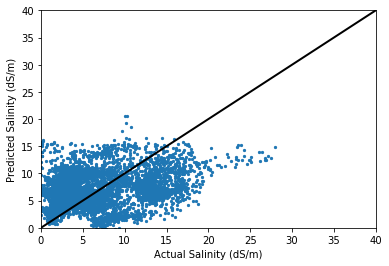

In [115]:
plot_actual_vs_predicted(y, y_hat)

In [116]:
print('MAE: %.2f' % np.mean(abs(y_hat - y)))
print('MSE: %.2f' % np.mean((y_hat-y)**2))
print('RMSE: %.2f' % np.mean(((y_hat-y)**2)**.5))
print('R_squared: %.2f' % r2_score(y, y_hat))

MAE: 4.25
MSE: 25.91
RMSE: 4.25
R_squared: -0.03
